In [231]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az

import pyro
import torch
import pyro.optim as optim
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, JitTrace_ELBO, Predictive, MCMC, NUTS
from pyro.distributions import constraints
from sklearn.preprocessing import StandardScaler

pyro.enable_validation(True)

# Type Level Model
Here, we will model each post as coming from one of four types.

# Data

First, we load the Reddit datasets

In [232]:
comments = dict()
with open('../data/results/Comments.json') as f:
    for line in f:
        post = json.loads(line)
        comments[post['pid']] = post['api_num_comments'], post['comments']

In [233]:
corrections = []
with open('../data/results/CorrectionPairs.json') as f:
    for line in f:
        corrections.append(json.loads(line))

In [234]:
news = []
with open('../data/results/NewsPairs.json') as f:
    for line in f:
        news.append(json.loads(line))

Gather relevant variables

In [235]:
def processData(data, items, comments, minutes=60, offset=0):
    for idx, n in enumerate(items):
        i = idx + offset
        
        isNews = 'isFakeStory' in n['r']['reviewRating']
        news_id = n['p']['id']
        
        num_cmts, cmts = comments[news_id]
        c_body_lens = []
        c_ups = []
        c_downs = []
        unique_authors = set()
        for c in cmts:
            # skip if comment not created in first _ mins
            if c['delta_seconds'] > minutes * 60:
                continue

            c_minutes = c['delta_seconds'] / 60
            if c_minutes <= minutes:   # cmts in first _ mins
                data[i, 7] += 1
            
            c_body_lens.append(c['body_len'])
            c_ups.append(c['ups'])
            c_downs.append(c['downs'])
            
            if c['author']:
                unique_authors.add(c['author'])

        data[i, 0] = num_cmts
        if isNews:
            data[i, 1] = 1 if n['r']['reviewRating']['isFakeStory'] else 0
        else:
            data[i, 1] = 3 if n['r']['reviewRating']['isFakeClaim'] else 2
        data[i, 2] = np.mean(c_body_lens) if c_body_lens else 0.
        data[i, 3] = np.std(c_body_lens) if c_body_lens else 0.
        data[i, 4] = np.mean(c_ups) if c_ups else 0.
        data[i, 5] = np.std(c_ups) if c_ups else 0.
        data[i, 6] = len(unique_authors) if unique_authors else 0.
    return data

In [236]:
num_p_indep = 8
data = np.zeros((len(news) + len(corrections), num_p_indep))

data = processData(data, news, comments)
data = processData(data, corrections, comments, offset=len(news))

Variables (in order):

0. num_comments
1. type
2. comment_length_avg
3. comment_length_std
4. comment_upvotes_avg
5. comment_upvotes_std
6. num_unique_comment_authors
7. num_comments in first _ mins

types

0. Real News
1. Fake News
2. Correction on Real News
3. Correction on Fake News

t level Variables (in order):

0. Is Review? (vs. news)
1. Is about fake story? (Not included yet)

In [237]:
# select relevant indep vars
p_data = data[:, (2,4,6,7)]  # avg cmt length, avg net upvotes, num authors, num initial comments
# normalize avg net upvotes by std net upvotes:
# TODO should we do this +1?
p_data[:,1] = data[:, 4] / (data[:, 5] + 1)

p_data = data[:,7].reshape(-1,1)  # num comments in 1st hr
p_types = data[:,1] # type of each post.

# This t_data is using the t-level variables above.
t_data = np.array([[0, 0],
                   [0, 1],
                   [1, 0],
                   [1, 1]])

# This t_data is just encoding each with its own dummy
t_data = np.array([[1, 0, 0, 0],
                   [0, 1, 0, 0],
                   [0, 0, 1, 0],
                   [0, 0, 0, 1]])


# add bias terms
p_bias = np.ones((p_data.shape[0],1))
t_bias = np.ones((t_data.shape[0],1))
p_data = np.concatenate((p_bias, p_data), axis=1)
t_data = np.concatenate((t_bias, t_data), axis=1)

# get dep var
y = data[:,0].reshape(-1,1)

### Data Transformations

In [238]:
# before we change anything, save the original p_data
original_p_data = p_data.copy()

In [239]:
original_p_data[:,0]

array([1., 1., 1., ..., 1., 1., 1.])

#### log some data.

In [240]:
# num initial comments
#p_data[:,4] = np.log(p_data[:,4] + 1)

# avg upvotes
# p_data[:,2] = np.log(p_data[:,2] + 1)

# num authors
#p_data[:,3] = np.log(p_data[:,3] + 1)

# avg comment len
p_data[:,1] = np.log(p_data[:,1] + 1)

In [243]:
# scale our data.
scaler = StandardScaler()
#p_data[:,[1,2,3,4]] = scaler.fit_transform(p_data[:,[1,2,3,4]])
p_data[:,[1]] = scaler.fit_transform(p_data[:,[1]])

split into train/test

In [244]:
train_frac = 0.7
num_obs = p_data.shape[0]
idx = np.random.binomial(1, train_frac, size=num_obs).astype(bool)

p_data_train = p_data[idx,:]
p_data_test = p_data[~idx,:]

p_types_train = p_types[idx]
p_types_test = p_types[~idx]

y_train = y[idx,:]
y_test = y[~idx,:]

-----

# Modeling

Cast data to torch tensors

In [245]:
p_data_train = torch.Tensor(p_data_train).double()
p_data_test = torch.Tensor(p_data_test).double()
p_types_train = torch.Tensor(p_types_train).double()
p_types_test = torch.Tensor(p_types_test).double()
y_train = torch.Tensor(y_train).double()
y_test = torch.Tensor(y_test).double()
t_data = torch.Tensor(t_data).double()

2 Regressions.

Post-Level Regression

y_pt = phi_0,t * bias + phi_1,t * first_hour_comments + epsilon_pt

Type-Level Regressions (2)

phi_0t = eta_00 * bias + eta_01 silliness_t + nu_0t

phi_1t = eta_10 * bias + eta_11 silliness_t + nu_1t

In [24]:
# def model(p_data, p_types, t_data, y):
#     num_posts, num_p_indeps = p_data.shape
#     num_types, num_t_indeps = t_data.shape
    
#     # define a prior for our regression variables
#     alpha_loc = torch.zeros((num_p_indeps, num_t_indeps))
#     alpha_scale = 1. * torch.ones((num_p_indeps, num_t_indeps))

#     with pyro.plate("t_indep", num_t_indeps, dim=-1) as ti:
#         with pyro.plate("p_indep1", num_p_indeps, dim=-2) as pi:
#             eta = pyro.sample("eta", dist.Normal(alpha_loc, alpha_scale))

    
    
#     with pyro.plate("type", num_types, dim=-1) as t:
#         with pyro.plate("p_indep2", num_p_indeps, dim=-2) as pi:
#             phi_loc = torch.matmul(eta, t_data[t,:].T) # (num_p_indeps, num_t_indeps) x (num_t_indeps, num_types)

#             phi_dist = dist.Normal(phi_loc, 0.1)
#             phi = pyro.sample("phi", phi_dist)
    
    
# #     pareto_alpha = pyro.sample("pareto_alpha", dist.HalfNormal(0.1))
        
#     # for each post, use the correct set of coefficients to run our post-level regression
#     with pyro.plate("post", num_posts, dim=-1) as p:
        
#         t = p_types[p].long()

#         # indep vars for this post
#         indeps = p_data[p,:]
        
#         coefs = phi[:,t] # (num_p_indeps,num_posts)

#         # calculate the mean: desired shape (num_posts, 1)
#         mu = torch.mul(coefs, indeps.T).sum(dim=0)  # ((num_p_indeps, num_posts) .* (num_p_indeps, num_posts)).sum(over indeps)
# #         print(f"mu: {mu.shape}")
# #         print(f"sigma (model): {sigma}")
#         # sample
# #         print(f"y: {y.shape}")
# #         print(f"pareto_alpha: {pareto_alpha.shape}")
# #         print(f"pareto_alpha: {pareto_alpha}")
        
#         print(y[p,0])
#         pyro.sample("obs", dist.Pareto(torch.ones((num_posts,)) - 1e-3, torch.exp(mu)), obs=y[p,0])


In [250]:
def model(p_data, p_types, t_data, y):
    num_posts, num_p_indeps = p_data.shape
    num_types, num_t_indeps = t_data.shape
    
    # define a prior for our regression variables
    alpha_loc = torch.zeros((num_p_indeps, num_t_indeps)).double()
    alpha_scale = 2. * torch.ones((num_p_indeps, num_t_indeps)).double()

    with pyro.plate("t_indep", num_t_indeps, dim=-1) as ti:
        with pyro.plate("p_indep1", num_p_indeps, dim=-2) as pi:
            eta = pyro.sample("eta", dist.Normal(alpha_loc, alpha_scale))

    
    
    with pyro.plate("type", num_types, dim=-1) as t:
        with pyro.plate("p_indep2", num_p_indeps, dim=-2) as pi:
            phi_loc = torch.matmul(eta, t_data[t,:].T) # (num_p_indeps, num_t_indeps) x (num_t_indeps, num_types)

            phi_dist = dist.Normal(phi_loc, 2.)
            phi = pyro.sample("phi", phi_dist)
    
    
#     pareto_alpha = pyro.sample("pareto_alpha", dist.HalfNormal(0.1))
    
    #subsample_size = 1000
        
    # for each post, use the correct set of coefficients to run our post-level regression
#    subsample_size=subsample_size,
    with pyro.plate("post", num_posts, dim=-1) as p:
        
        t = p_types[p].long()

        # indep vars for this post
        indeps = p_data[p,:]
        
        coefs = phi[:,t] # (num_p_indeps,num_posts)

        # calculate the mean: desired shape (num_posts, 1)
        mu = torch.mul(coefs, indeps.T).sum(dim=0)  # ((num_p_indeps, num_posts) .* (num_p_indeps, num_posts)).sum(over indeps)
#        print(f"mu: {mu}")
#        print(f"exp mu: {torch.exp(mu)}")
#         print(f"sigma (model): {sigma}")
        # sample
#         print(f"y: {y.shape}")
#         print(f"pareto_alpha: {pareto_alpha.shape}")
#         print(f"pareto_alpha: {pareto_alpha}")
        if y is not None:
            pyro.sample("obs", dist.Poisson(torch.exp(mu)), obs=y[p,0])
        else:
            pyro.sample("obs", dist.Poisson(torch.exp(mu)), obs=y)


In [251]:
def guide(p_data, p_types, t_data, y):
    num_posts, num_p_indeps = p_data.shape
    num_types, num_t_indeps = t_data.shape
    
    # define a prior for our regression variables
    
    alpha_loc = torch.zeros((num_p_indeps, num_t_indeps), dtype=torch.float64)
    alpha_scale = 2. * torch.ones((num_p_indeps, num_t_indeps), dtype=torch.float64)
    
    # The zeros and ones are the "alpha" in the graphical model from the proposal
    eta_loc = pyro.param("eta_loc", alpha_loc)
    eta_scale = pyro.param("eta_scale", alpha_scale, constraint=constraints.positive)
            
    with pyro.plate("t_indep", num_t_indeps, dim=-1) as ti:
        with pyro.plate("p_indep1", num_p_indeps, dim=-2) as pi:
            eta = pyro.sample("eta", dist.Normal(eta_loc, eta_scale))
    
    phi_scale = pyro.param("phi_scale", 
                           2. * torch.ones((num_p_indeps, 1), dtype=torch.float64), 
                           constraint=constraints.positive) # share among all types.
    
    with pyro.plate("type", num_types, dim=-1) as t:
        with pyro.plate("p_indep2", num_p_indeps, dim=-2) as pi:
            phi_loc = torch.matmul(eta, t_data[t,:].T) # (num_p_indeps, num_t_indeps) x (num_t_indeps, num_types)

            phi = pyro.sample("phi", dist.Normal(phi_loc, phi_scale[:]))


In [252]:
pyro.clear_param_store()

## Traces (to double check tensor shapes)

# Inference

## SVI

In [253]:
SUBSAMPLE = False

# svi = SVI(model,
#           guide,
#           optim.Adam({"lr": 1e-3}),
#           loss=JitTrace_ELBO())

svi = SVI(model,
          guide,
          optim.ClippedAdam({"lr": 1e-3}),
          loss=JitTrace_ELBO())

pyro.clear_param_store()
num_iters = 10000
losses = np.zeros((num_iters,))
for i in range(num_iters):
    if SUBSAMPLE:
        elbo = svi.step(p_data_train[:250], p_types_train[:250], t_data, y_train[:250])
    else:
        elbo = svi.step(p_data_train, p_types_train, t_data, y_train)
    losses[i] = elbo
    if i % 100 == 0:
        print("Elbo loss: {}".format(elbo))

Elbo loss: 1.0460417159001324e+25
Elbo loss: 3.230926696129485e+33
Elbo loss: 29562586.109143242
Elbo loss: 150883318.89418072
Elbo loss: 3060744.3785951827
Elbo loss: 2994311.2824643804
Elbo loss: 1756352.2866865594
Elbo loss: 1.3382758135429664e+20
Elbo loss: 3637884.1688413587
Elbo loss: 6386249.309340246
Elbo loss: 108297051.41825454
Elbo loss: 2878249481536177.0
Elbo loss: 3220911.3646217748
Elbo loss: 1280056.8040197212
Elbo loss: 2941987.382386891
Elbo loss: 1399740.4687551039
Elbo loss: 5550700191565.84
Elbo loss: 2675333.897716664
Elbo loss: 4070008.673100253
Elbo loss: 2.8771501471009096e+16
Elbo loss: 103191779.03551163
Elbo loss: 526404031042.719
Elbo loss: 305008134020472.7
Elbo loss: 20766968637.45691
Elbo loss: 274246914.61147594
Elbo loss: 80978314.33467244
Elbo loss: 13680304.197585143
Elbo loss: 18228024.682800945
Elbo loss: 1877640.394149912
Elbo loss: 4764127019.901672
Elbo loss: 3292281.420961472
Elbo loss: 1245119.0910673172
Elbo loss: 1845207.592813528
Elbo loss:

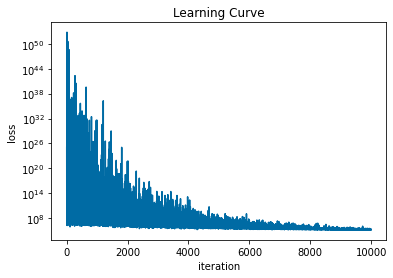

In [254]:
plt.plot(range(len(losses)), np.array(losses))
plt.xlabel('iteration')
plt.ylabel('loss')
plt.yscale("log")
plt.title("Learning Curve")
plt.show()

In [255]:
num_samples = 1000
predictive = Predictive(model, guide=guide, num_samples=num_samples)
svi_samples = {k: v.reshape((1,num_samples,-1)).detach().cpu().numpy()
               for k, v in predictive(p_data_test, p_types_test, t_data, y_test).items()
               if k != "obs"}

----

In [35]:
import pyro.poutine as poutine

In [36]:
trace = poutine.trace(model).get_trace(p_data_train[:1000], p_types_train[:1000], t_data, y_train[:1000])
trace.compute_log_prob()  # optional, but allows printing of log_prob shapes
print(trace.format_shapes())

mu: tensor([11.4008,  0.0912,  0.0912,  0.0912,  0.0912,  0.0912,  0.0912,  0.0912,
         0.0912,  0.0912,  0.0912,  0.0912,  0.0912,  0.0912,  0.0912,  8.0046,
         2.1577,  2.1577,  2.1577,  2.1577,  2.1577,  2.1577,  2.1577,  2.1577,
         2.1577,  2.1577,  2.1577,  2.1577,  2.1577, 10.2936,  2.1577,  2.1577,
         2.1577,  2.1577,  2.1577, 13.4407,  8.6013,  2.1577,  2.1577,  2.1577,
         2.1577,  2.1577,  2.1577,  2.1577,  2.1577,  0.0912,  0.0912,  0.0912,
         0.0912,  0.0912,  0.0912,  2.8366,  0.0912,  3.5546,  0.0912,  0.0912,
         2.1577,  2.1577,  2.1577,  2.1577,  2.1577,  0.0912,  0.0912,  0.0912,
         2.1577,  2.1577,  0.0912,  0.0912,  0.0912,  0.0912,  0.0912,  2.1577,
         2.1577,  2.1577,  0.0912,  3.4680,  0.0912,  0.0912,  0.0912,  0.0912,
         0.0912,  2.4967,  0.0912,  0.0912,  0.0912,  0.0912,  0.0912,  0.0912,
         3.7359,  0.0912,  0.0912,  0.0912,  0.0912,  4.9569,  0.0912,  5.1822,
         2.7888,  2.3708,  2.1800,  

In [30]:
trace = poutine.trace(guide).get_trace(p_data_train[:1000], p_types_train[:1000], t_data, y_train[:1000])
trace.compute_log_prob()  # optional, but allows printing of log_prob shapes
print(trace.format_shapes())

TypeError: get_param() got an unexpected keyword argument 'dtype'

## MCMC (NUTS)

In [219]:
kernel = NUTS(model_no_subsample)

num_iters = 1000
warmup_steps = 500
mcmc = MCMC(kernel, num_samples=num_iters, warmup_steps=warmup_steps)
mcmc.run(p_data_train[:100], p_types_train[:100], t_data, y_train[:100])

Sample: 100%|██████████| 1500/1500 [15:42,  1.59it/s, step size=3.03e-01, acc. prob=0.907]


In [220]:
posterior_samples = mcmc.get_samples()

In [221]:
eta_means = posterior_samples["eta"].mean(dim=0)
eta_means

tensor([[ 1.6130,  0.9486,  0.4208],
        [ 0.0321,  0.1046, -0.1149]])

In [222]:
phi_means = posterior_samples["phi"].mean(dim=0)
phi_means

tensor([[ 2.1388e+00,  2.1391e+00,  2.3892e+00,  3.1243e+00],
        [-2.9254e-05, -8.9008e-05,  7.0442e-01,  4.2145e-01]])

# Evaluation

Recall:

Variables (in order):

0. num_comments
1. type
2. comment_length_avg
3. comment_length_std
4. comment_upvotes_avg
5. comment_upvotes_std
6. num_unique_comment_authors
7. num_comments in first _ mins

types

0. Real News
1. Fake News
2. Correction on Real News
3. Correction on Fake News

t level Variables (in order):

0. Is Review? (vs. news)
1. Is about fake story? (Not included yet)

Check the fit

In [101]:
print(pyro.param('eta_loc'))

tensor([[-3.2560,  3.1329,  2.0277,  1.9451,  1.7799],
        [-2.8901,  3.0610,  2.7244,  2.6189,  2.2929],
        [-2.0765,  1.8524,  2.1886,  2.3418,  2.3571],
        [-2.2776,  2.7548,  2.8747,  2.9140,  2.8543],
        [-2.3736,  2.6874,  2.8706,  2.8496,  2.7248]], dtype=torch.float64,
       requires_grad=True)


2 Regressions.

Post-Level Regression

y_pt = phi_0,t * bias + phi_1,t * first_hour_comments + epsilon_pt

Type-Level Regressions (2)

phi_0t = eta_00 * bias + nu_0t

phi_1t = eta_10 * bias + nu_1t

In [256]:
labels = np.array(["Factual News", "Fake News", "Review of Factual News", "Review of Fake News"])

<ipython-input-259-70a346077f57>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  coefs = torch.tensor(phi[:,t]) # (num_p_indeps,num_posts)


(21830, 1)


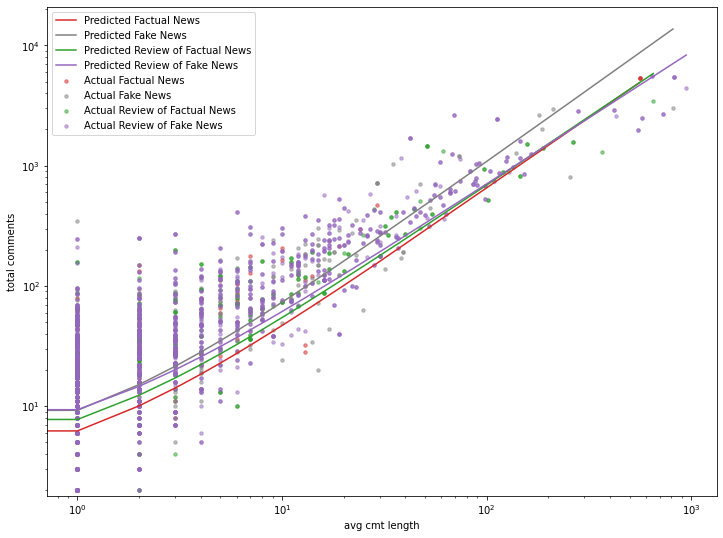

In [259]:
indep = 1

indep_dict = {
    1: "avg cmt length",
    2: "avg upvotes",
    3: "num authors",
    4: "comments in first hour",
}
# indep_dict = {
#     1: "comments in first hour",
# }

use_MCMC = False

if use_MCMC:
    eta_loc = eta_means
else:
    eta_loc = pyro.param('eta_loc').detach()

# eta_loc = torch.Tensor([[ 0.2019, -0.0130,  0.1875],
#                         [ 0.3866, -0.6894,  0.0956]]

phi = torch.matmul(eta_loc, t_data.T)

t = torch.Tensor(p_types).long()

indeps = torch.tensor(p_data)

coefs = torch.tensor(phi[:,t]) # (num_p_indeps,num_posts)

mu = torch.mul(coefs, indeps.T).sum(dim=0)

y_pred = np.exp(mu)



print(y.shape)



# y_pred_mcmc = float(phi_means[0])
# y_pred_mcmc += float(phi_means[1]) * p_data[:,indep]


plt.figure(figsize=(12,9))

types = np.unique(p_types)

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
color_choices = np.random.choice(colors, size=len(types), replace=False)



for i, t in enumerate(types):
#     if t == 2:
        y_pred_t = y_pred[p_types == t]
        y_t = 1 * y[p_types == t]
        x_t = original_p_data[p_types == t,indep]
        
        sorted_indices = np.argsort(x_t)

        type_label = labels[int(t)]

        color = color_choices[i]
        plt.scatter(x_t, y_t, alpha=0.5, s=12, c=color, label=f"Actual {type_label}")
        plt.plot(x_t[sorted_indices], y_pred_t[sorted_indices], c=color, label=f"Predicted {type_label}")
    
# plt.plot(np.array(p_data[:,indep]), np.array(y_pred_mcmc), c='tab:green', label=f'MCMC: {phi_means[0]}, {phi_means[1]}') # MCMC
plt.xlabel(indep_dict[indep])
plt.ylabel('total comments')

plt.yscale("log")
plt.xscale("log")
plt.legend()
# plt.ylim(0,20)
# plt.xlim(0,10)
plt.show()

Interpretation:

- For posts with no comments in the first hour, we expect 7.23 comments in total
- For every comment in the first hour, we expect an additional 6.43 comments in total

----

In [80]:
data = az.from_pyro(mcmc)
az.plot_trace(data, compact=False);

NameError: name 'mcmc' is not defined

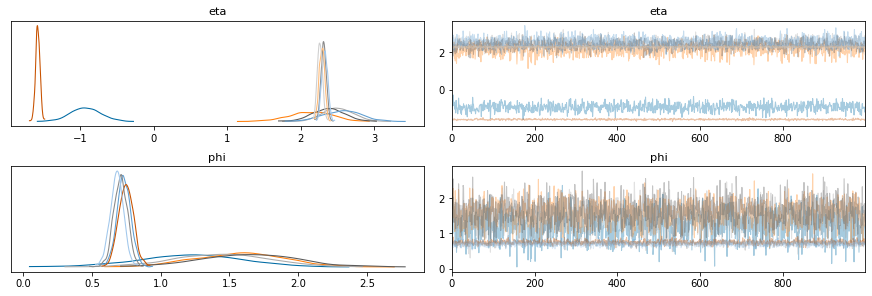

In [260]:
az_samples = az.convert_to_inference_data(svi_samples)
az.plot_trace(az_samples, compact=True);

In [267]:
num_samples = 1000
predictive = Predictive(model, guide=guide, num_samples=num_samples)
svi_samples = {k: v.reshape((1,num_samples,-1)).detach().cpu().numpy()
               for k, v in predictive(p_data_train, p_types_train, t_data, None).items()}

In [272]:
svi_az = az.convert_to_inference_data({'obs': svi_samples['obs']}, group='posterior_predictive')

In [273]:
svi_az.add_groups({'posterior': {'phi': svi_samples['phi'], 'eta': svi_samples['eta']}})

In [274]:
svi_az.add_groups({'observed_data': {'obs': y_train.reshape(1,1,-1)}})

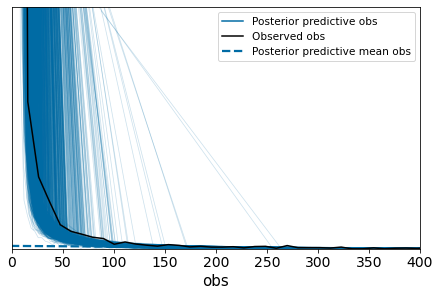

In [281]:
az.plot_ppc(svi_az)
#plt.xscale('log')
#plt.yscale('log')
plt.xlim(0, 400)
plt.ylim(0, 0.05)
plt.show()

# Why Pareto?
Our distribution of total comments follows a power law.

Text(0, 0.5, 'frequency')

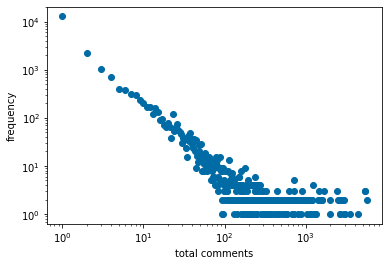

In [97]:
max_ct = np.max(y)
unique, counts = np.unique(y, return_counts=True)
plt.scatter(unique, counts)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("total comments")
plt.ylabel("frequency")
plt.show()

Fake news: expect relatively flatter (more with lots, fewer with few!)

Reviews: expect steeper (fewer comments very common)

Note that our first hour comments are also distributed similarly.

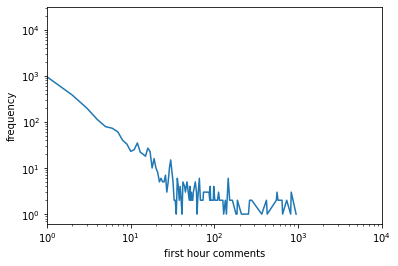

In [12]:
max_ct = np.max(p_data[:,1])
unique, counts = np.unique(p_data[:,1], return_counts=True)
plt.plot(unique, counts)
plt.yscale("log")
plt.xscale("log")
plt.xlim(1, 10000)
plt.xlabel("first hour comments")
plt.ylabel("frequency")
plt.show()

In [93]:
p_data[:,1].shape

(21830,)